In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
import keras

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from keras.models import Model
from keras.layers import Lambda
from keras.layers  import Dense, Input, Flatten,multiply,Conv2D, MaxPool2D, Dropout, Reshape,Concatenate,BatchNormalization, Dot, Add
from keras.layers.embeddings import Embedding
# from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


<b>Out of Session testing

In [0]:
def test_model(model,test_data):
    with (open(test_file, "rb")) as openfile:
        test_data=pkl.load(openfile)
    X_b_test=np.array(test_data["bill2idx"].values.tolist())
    X_l_test=np.array(test_data["leg_index"].values.tolist())
    pr_test=np.array(test_data["r_perc"].values.tolist())
    pd_test=np.array(test_data["d_perc"].values.tolist())
    Y_test=np.array(test_data["vote"].values.tolist())
    del test_data
    loss,acc = model.evaluate([X_b_test,X_l_test,pr_test,pd_test], Y_test,verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], acc*100))
    return acc


##CNN Text Only Model

In [0]:
def model_CNN(n_leg,max_len=400,convActivation='relu',optimizer='adamax',filter_size=4,dropout_rate=0.6,num_filters=128):
    """
    Function creating the vote_prediction model's graph.
    
    Arguments:
    n_leg -- number of unique legislators
    
    Returns:
    model -- a static Nmodel instance in Keras
    """
    #CNN with 4-gram and 400 filters specified. this is single channel model
    #filter size= n-gram or number of words filter is applied to
    
    bill_indices = Input(shape=(max_len,),dtype='int32',name="bill_in")
    with (open("/content/drive/My Drive/app1/data/emb_matrix.pkl","rb")) as openfile:
        emb_matrix=pkl.load(openfile)

    embedding_layer = Embedding(output_dim=50,input_dim=emb_matrix.shape[0],weights=[emb_matrix],input_length=max_len,trainable=False)
    bill_emb = embedding_layer(bill_indices)
    del emb_matrix
#---------------------------------------------
    bill_emb = Reshape((max_len,50,1))(bill_emb)
    bill_emb = BatchNormalization()(bill_emb)
    bill_emb=Dropout(0.2)(bill_emb)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_size, 50),
                    padding='valid', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform',activation=convActivation)(bill_emb)
    maxpool_1 = MaxPool2D(pool_size=(max_len - filter_size + 1, 1),
                          strides=(1,1), padding='valid')(conv_1)
    xb = Flatten()(maxpool_1)
#     model.add(LSTM(400))
    xb = Dropout(dropout_rate)(xb)

    xb = Dense(25,kernel_initializer='glorot_uniform',name="xb")(xb)
    pr=Input(shape=(1,),dtype='float32',name='r_perc')
    pd=Input(shape=(1,),dtype='float32',name='d_perc')
    ar=Dense(25,use_bias=False, kernel_initializer='glorot_uniform')(pr)
    ar=Dropout(0.2)(ar)
    ad=Dense(25,use_bias=False, kernel_initializer='glorot_uniform')(pd)
    ad=Dropout(0.2)(ad)
    br=multiply([ar,xb])
    bd=multiply([ad,xb])
    xb=Add()([br,bd])
    
    leg_in= Input(shape=(1,), dtype='int64', name='legislator_index')
    xl=Embedding(input_dim=n_leg,output_dim= 25, input_length=1,embeddings_initializer='glorot_uniform',name="xl",trainable=True)(leg_in)
    xl=Dropout(0.2)(xl)
    xl=Flatten()(xl)
    x=multiply([xb,xl])
    x=Dense(1,activation='sigmoid',bias_initializer='glorot_uniform',kernel_initializer='glorot_uniform')(x)
    
    # Create Model instance which converts bill and leg id into vote prediction x.
    model = Model([bill_indices,leg_in,pr,pd],x)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Baseline Model

In [0]:
# kfold=KFold(5,True,42) #True: shuffle, 1: seed
# # # n_l=len(data.leg_index.unique())+1
# # # cvscores=[]
# # # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=7,min_delta=0.1,baseline=.1)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
# with (open("/content/drive/My Drive/app1/data/data_Final_20052012.pkl", "rb")) as openfile:
#   data=pkl.load(openfile)
# histories=[]
# split=kfold.split(data)
# train, test =next(split)

# model_in = model_CNN(n_l)    

# data_train=data.iloc[train]
# data_test=data.iloc[test]
# data_test=data_test[data_test.leg_index.isin(data_train.leg_index)]


# X_b_train=np.array(data_train["bill2idx"].values.tolist())
# X_l_train=np.array(data_train["leg_index"].values.tolist())
# Y_train=np.array(data_train["vote"].values.tolist())


# X_b_test=np.array(data_test["bill2idx"].values.tolist())
# X_l_test=np.array(data_test["leg_index"].values.tolist())
# Y_test=np.array(data_test["vote"].values.tolist())
# del data,data_train, data_test
# history=model_in.fit([X_b_train,X_l_train], Y_train,validation_data=([X_b_test,X_l_test], Y_test),initial_epoch = 0, epochs =22, batch_size = 32,verbose=0,callbacks=[mc])

# histories.append(history)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()

Train and Test: Out of Session

Compile CNN Model

In [5]:
mc = ModelCheckpoint('/content/drive/My Drive/best_model_CNNMeta.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)
with (open("/content/drive/My Drive/app1/data/data_Final_20052012.pkl", "rb")) as openfile:
  data=pkl.load(openfile)
n_l=len(data.leg_index.unique())
labels=np.array(data["vote"].values.tolist())
X_b=np.array(data["bill2idx"].values.tolist())
X_l=np.array(data["leg_index"].values.tolist())
pr=np.array(data["r_perc"].values.tolist())#685091
pd=np.array(data["d_perc"].values.tolist())

x_b_train, x_b_valid, x_l_train, x_l_valid, pr_train, pr_valid, pd_train, pd_valid, y_train, y_valid = train_test_split(X_b,X_l,pr, pd,labels , test_size=0.2, stratify=labels)

## x_b_train, x_b_valid, x_l_train, x_l_valid, y_train, y_valid = train_test_split(X_b,X_l,labels , test_size=0.2, stratify=labels)

del data,X_b,X_l,labels,pd,pr
model_in = model_CNN(n_l) 

history=model_in.fit([x_b_train,x_l_train,pr_train,pd_train], y_train,validation_data=([x_b_valid,x_l_valid,pr_valid,pd_valid], y_valid),initial_epoch = 0, epochs =20, batch_size = 32,verbose=0,callbacks=[mc])



W0708 18:18:36.566520 139930610169728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 18:18:37.271154 139930610169728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 18:18:37.272779 139930610169728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 18:18:37.296011 139930610169728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 18:18:37.296903 1399306101


Epoch 00001: val_acc improved from -inf to 0.90185, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00002: val_acc improved from 0.90185 to 0.91242, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00003: val_acc improved from 0.91242 to 0.91618, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00004: val_acc improved from 0.91618 to 0.91948, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00005: val_acc improved from 0.91948 to 0.92046, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00006: val_acc improved from 0.92046 to 0.92262, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00007: val_acc improved from 0.92262 to 0.92421, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00008: val_acc improved from 0.92421 to 0.92427, saving model to /content/drive/My Drive/best_model_CNNMeta.h5

Epoch 00009: val_acc improved from 0.92427 to 0.92482, sav

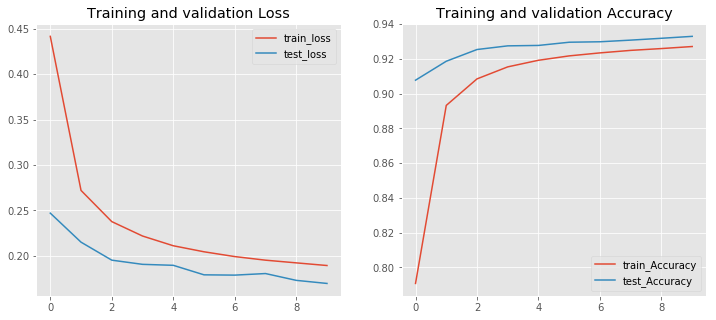

In [0]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title('Training and validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='train_Accuracy')
plt.plot(history.history['val_acc'], label='test_Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.show()

CV In session

In [6]:
best_model = load_model(filepath='/content/drive/My Drive/best_model_CNNMeta.h5')
test_file="/content/drive/My Drive/app1/data/data_Final_20132014.pkl"
test_model(best_model,test_file)

W0708 19:02:52.832127 139930610169728 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


acc: 81.43%


0.8142923248172139

In [7]:
test_file="/content/drive/My Drive/app1/data/data_Final_20152016.pkl"
test_model(best_model,test_file)

acc: 70.60%


0.7060296768244121